In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Tạo thư mục nếu chưa có
import os
os.makedirs("../data/processed", exist_ok=True)

# Lưu dữ liệu Profiling phục vụ Dashboard
profile_mean.to_csv("../data/processed/cluster_profiles.csv")

# Lưu cả danh sách khách hàng kèm nhãn cụm để Dashboard có thể lọc chi tiết
# Giả sử 'features_advanced' là ma trận đặc trưng bạn đã dùng để phân cụm
customer_results = pd.DataFrame({'Cluster': labels}, index=features_advanced.index)
customer_results.to_csv("../data/processed/customer_segments.csv")

print("Đã lưu tất cả kết quả thành công!")

Đã lưu tất cả kết quả thành công!


In [9]:
import pandas as pd
import re

# 1. Đọc danh sách luật
rules_path = "../data/processed/rules_fpgrowth_filtered.csv"
rules_df = pd.read_csv(rules_path)

# Hàm xử lý chuỗi "frozenset({'item'})" thành frozenset({'item'}) chuẩn
def clean_frozenset_string(s):
    if pd.isna(s): return frozenset()
    # Tìm tất cả nội dung nằm trong dấu nháy đơn '' hoặc nháy kép ""
    items = re.findall(r"['\"](.*?)['\"]", str(s))
    return frozenset(items)

# 2. Áp dụng hàm làm sạch dữ liệu
rules_df['antecedents'] = rules_df['antecedents'].apply(clean_frozenset_string)
rules_df['consequents'] = rules_df['consequents'].apply(clean_frozenset_string)

print("Đã làm sạch dữ liệu luật thành công!")

Đã làm sạch dữ liệu luật thành công!


In [10]:
# Đọc dữ liệu đã làm sạch
df_clean = pd.read_csv("../data/processed/cleaned_uk_data.csv", parse_dates=['InvoiceDate'])

# Tính toán RFM
latest_date = df_clean['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm_df = df_clean.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (latest_date - x.max()).days, # Recency
    'InvoiceNo': 'nunique',                               # Frequency
    'TotalPrice': 'sum'                                   # Monetary
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalPrice': 'Monetary'
})

print("Đã tạo bảng RFM:")
display(rfm_df.head())

/var/folders/tk/3yrv6xbs6nn_36d0y_7hvg9w0000gn/T/ipykernel_33219/756893625.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_clean = pd.read_csv("../data/processed/cleaned_uk_data.csv", parse_dates=['InvoiceDate'])


Đã tạo bảng RFM:


,Recency,Frequency,Monetary
CustomerID,,,
000nan,1,1373,1716830.53
012346,326,1,77183.60
012747,2,11,4196.01
012748,1,209,33719.73
012749,4,5,4090.88


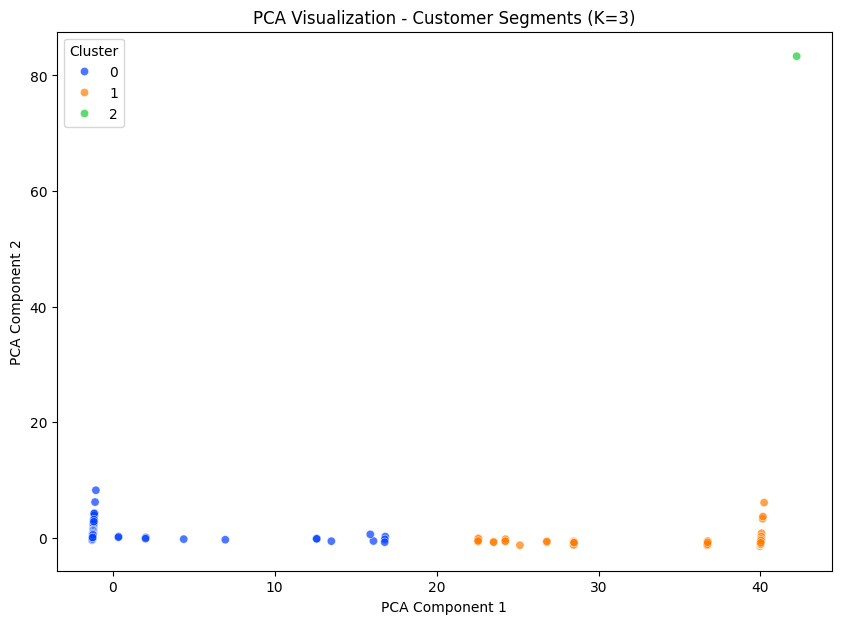

In [11]:
# 3. Tạo ma trận khách hàng - sản phẩm
customer_item_matrix = df_clean.groupby(['CustomerID', 'Description']).size().unstack(fill_value=0) > 0

# 4. Tạo đặc trưng Nâng cao (Weighted Rules + RFM) - Yêu cầu 2
clusterer.load_rules(rules_df, top_k=50)
features_advanced = clusterer.build_final_features(
    customer_item_matrix, 
    rfm_df=rfm_df, 
    weighting='weighted'
)

# 5. Tìm K và Phân cụm - Yêu cầu 3
best_k, k_range, scores = clusterer.get_best_k(max_k=12)
labels = clusterer.fit_kmeans(k=best_k)

# 6. Trực quan hóa PCA - Yêu cầu 4
clusterer.visualize_clusters(labels)

In [12]:
# Lưu bảng Profiling
cluster_size, profile_mean = clusterer.get_cluster_profiles(labels)
profile_mean.to_csv("../data/processed/cluster_profiles.csv")

# Lưu nhãn cụm cho từng khách hàng (để Dashboard lọc)
customer_segments = pd.DataFrame({'Cluster': labels}, index=features_advanced.index)
customer_segments.to_csv("../data/processed/customer_segments.csv")

print("Đã lưu kết quả thành công! Bạn có thể mở Dashboard Streamlit ngay bây giờ.")

Đã lưu kết quả thành công! Bạn có thể mở Dashboard Streamlit ngay bây giờ.


In [18]:
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def cluster_rules(rules_df, n_clusters=5):
    """Phân cụm các luật dựa trên sự tương đồng của sản phẩm (Yêu cầu mở rộng 2)"""
    # Tạo ma trận Rule x Product
    all_items = set()
    rules_df['all_items'] = rules_df.apply(lambda x: x['antecedents'] | x['consequents'], axis=1)
    for items in rules_df['all_items']:
        all_items.update(items)
    
    item_list = sorted(list(all_items))
    rule_item_matrix = np.zeros((len(rules_df), len(item_list)))
    
    for i, items in enumerate(rules_df['all_items']):
        for item in items:
            rule_item_matrix[i, item_list.index(item)] = 1
            
    # Phân cụm luật
    km = KMeans(n_clusters=n_clusters, random_state=42)
    rule_labels = km.fit_predict(rule_item_matrix)
    rules_df['Rule_Cluster'] = rule_labels
    
    return rules_df, rule_item_matrix

# Thực thi
rules_clustered, matrix = cluster_rules(rules_df)
print("Ví dụ sản phẩm trong Cụm Luật 0:", list(rules_clustered[rules_clustered['Rule_Cluster']==0]['all_items'].iloc[0]))
import re

def clean_frozenset_string(s):
    if pd.isna(s): return frozenset()
    # Tìm tất cả nội dung nằm trong dấu nháy đơn hoặc kép
    items = re.findall(r"['\"](.*?)['\"]", str(s))
    return frozenset(items)

# Áp dụng cho rules_df
rules_df['antecedents'] = rules_df['antecedents'].apply(clean_frozenset_string)
rules_df['consequents'] = rules_df['consequents'].apply(clean_frozenset_string)

Ví dụ sản phẩm trong Cụm Luật 0: ['CHARLOTTE BAG PINK POLKADOT', 'RED RETROSPOT CHARLOTTE BAG', 'LUNCH BAG SPACEBOY DESIGN ']
